<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we use four different classification algorithms to predict if a customer will pay off their loan on time or not. This is a binary classification problem.   
We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression

The end-to-end pipeline used in this project composed of these steps: 
1. Download .CSV data from web
2. Exploratory data analysis/visualization
3. Feature(s) selection/creation (feature engineering)
4. Data cleaning/pre-processing
5. Predictive modeling based on loaded data:
    - Tune model parameter based on mode accuracy using k-fold cross-validation
    - Build final model
6. Use models to predict the target variable in new data
7. Report model accuracies and suggest the best classifier


#### Import libraries:

In [1]:
# import itertools # Functions creating iterators for efficient looping
import numpy as np # Support for large multi-dimensional matrices and high-level mathematical functions
import matplotlib.pyplot as plt # Visualization
# from matplotlib.ticker import NullFormatter
import pandas as pd # Data manipulations and analysis of numerical tables and time-series
# import matplotlib.ticker as ticker
from sklearn import preprocessing #provides common utility functions to change raw feature vectors into a representation that is more suitable for the downstream estimators.
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
%matplotlib inline 

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

## 1. Download loan data 
This data will be used to train models

In [2]:
!wget -O loan_train.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
print('Download compelete!')    
# !wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2019-02-24 22:59:14--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_train.csv
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/plain]
Saving to: 'loan_train.csv'

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.03s   

2019-02-24 22:59:14 (859 KB/s) - 'loan_train.csv' saved [23101/23101]

Download compelete!


#### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

## 2. Exploratory data analysis/visualization

#### 2.1 Check the type of fields/features

In [5]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

Notice that "effective_date" and "due_date" are objects. We first convert their type to "date time".

#### 2.2 Convert to date-time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
# print('Type of \'due date\': {}'.format(df[['due_date']].dtypes))
df.dtypes[5:7]

effective_date    datetime64[ns]
due_date          datetime64[ns]
dtype: object

In [7]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


#### 2.3 Exploratory analysis of features

**2.3.1** What is the max and min of 'Principal' and 'terms'?

In [8]:
print('Principal max:{}, min:{}'.format(df['Principal'].max(),df['Principal'].min()))
print('Terms max:{}, min:{}'.format(df['terms'].max(),df['terms'].min()))

Principal max:1000, min:300
Terms max:30, min:7


**2.3.2** What different categories are under 'loan_status'?

In [9]:
df['loan_status'].unique()

array(['PAIDOFF', 'COLLECTION'], dtype=object)

**2.3.3** How many of each 'loan status' classes are in data set? 

In [10]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


In [11]:
df['loan_status'].value_counts(normalize=True)

PAIDOFF       0.751445
COLLECTION    0.248555
Name: loan_status, dtype: float64

75% have paid off their loan on time while 25% have gone into collection.

** 2.3.5**  What are the different categories under 'education' field?

In [12]:
x=df['education'].unique()
print('education levels: {}'.format(x))

education levels: ['High School or Below' 'Bechalor' 'college' 'Master or Above']


**2.3.6** How many people are there per each educational level?

In [13]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

**2.3.7**  Compare loan payment between male and female groups

In [14]:
df['Gender'].value_counts(normalize=True)

male      0.849711
female    0.150289
Name: Gender, dtype: float64

Male and female population 85%, 15%

In [15]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

About %86 of female population paid of their loan on time while this percentage is 73% for male population. This indicates that the **'gender'** feature might be a good candidate to predict the loan_status.

**2.3.8** Compare loan payment between groups with different educational backgrounds.

In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

This shows PAIDOFF rate is almost same between different educational groups, except the group with Master or Above, but notice that there are only 2 people in this category. So in summary **education level** does not seem to have any effect on paying of the loan on time.

**2.3.9** Compare loan payment between groups with different principal amount

In [17]:
df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

In [18]:
df.groupby(['Principal'])['loan_status'].value_counts(normalize=True)

Principal  loan_status
300        PAIDOFF        1.000000
500        PAIDOFF        1.000000
800        PAIDOFF        0.777778
           COLLECTION     0.222222
900        PAIDOFF        1.000000
1000       PAIDOFF        0.736434
           COLLECTION     0.263566
Name: loan_status, dtype: float64

No difference based on **Principal** amount.

#### 2.4 Exploratory visualization:

In [19]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

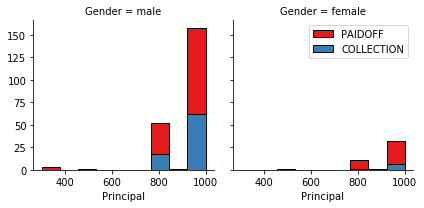

In [20]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

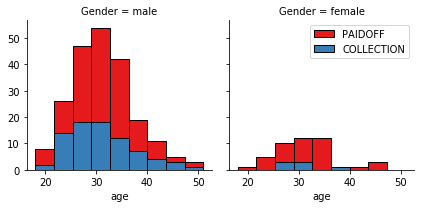

In [21]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

These graphs show that ignoring the 'gender' feature the on-time loan payment does not depend significantly on  'Principal' and 'Age' factors.

## 3. Feature(s) selection/creation (feature engineering)

Look at the day of the week people get the loan 

In [22]:
df['dayofweek'] = df['effective_date'].dt.dayofweek # Monday:0, Sunday:6
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4


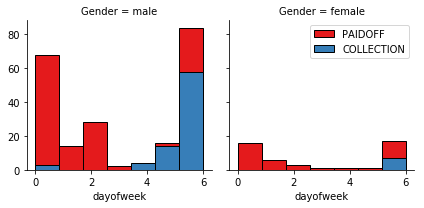

In [23]:
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use **Feature binarization** to set a threshold values less then day 4 

In [24]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## 4. Data cleaning/pre-processing

#### 4.1 Convert Categorical features to numerical values

Convert male to 0 and female to 1:


In [25]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### 4.2 One Hot Encoding  

What is one hot coding?  
Wikipedia: "In digital circuits and machine learning, one-hot is a group of bits among which the legal combinations of values are only those with a single high (1) bit and all the others low (0). A similar implementation in which all bits are '1' except one '0' is sometimes called one-cold. In statistics, dummy variables represent a similar technique for representing categorical data."  
<a href="https://en.wikipedia.org/wiki/One-hot"><img src="https://chrisalbon.com/images/machine_learning_flashcards/One-Hot_Encoding_print.png" width="600" align="center">

Feature table before One Hot Encoding:

In [26]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


Use one hot encoding technique to convert categorical varables to binary variables and append them to the feature Data-Frame:

In [27]:
pd.get_dummies(df['education']).head()

,Bechalor,High School or Below,Master or Above,college
0,0,1,0,0
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1


In [54]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
# Drop rows with education feature of'Master or Above':
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


#### 4.2 Create Features dataset

Lets defind feature sets, X:

In [55]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


#### 4.3 Create Target variable
The target attribute is a categorical variable with values: **[PAIDOFF**, **COLLECTIONS]**.  
That is why we will use classification models (and not the regression models) to predict the target variable.  
Since there are only two possible categories for target variable, the classification is a binary one.

In [56]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

#### 4.4 Normalize Data 

Data Standardization: give data zero mean and unit variance. 
Many machine learning algorithms work based on Eucledian or similar measures of distance and normalization of data is a rquired step before applying almost of the Machine learning algorithms.

In [57]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108]])

## 5. Predictive modeling based on loaded data: 

#### Parameter tuning with cross-validation  
Parameter tuning for each machine learning model: Find the model parameter value to build the model with best accuracy. The model accuracy is evaluated by performing **10-fold cross-validation**. The model accuracy is measured using:
- **F1-score**:weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is: $$F1 = 2 * \frac{\text{precision} *\text{ recall}}{\text{precision} + \text{recall}}$$ Precision and recall are demonstrated as: <a href="https://en.wikipedia.org/wiki/Precision_and_recall"><img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg" width="200" align="center"></a>
    - Precision: What proportion of positive identifications was actually correct? $$\text{Precision}= \frac{\text {TP}}{\text{TP+FP}}$$
    - Recall (sensitivity): What proportion of actual positives was identified correctly? $$\text{Precision}= \frac{\text {TP}}{\text{TP+FN}} $$
- **Jaccard similarity index**: The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union 

Function to cimnpoute model accuracy using k-fold cross-validation:

In [58]:
def model_eval_plt(par, Jac, model_name, model_par_name):
    # plot model accuracy for different values of k (k: number of neighbors)
    plt.figure(figsize=(10,5))
    plt.plot(par, Jac, 'b', linewidth = 2)
    plt.legend(['Jaccard'], fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)
    plt.xlabel('{}'.format(model_par_name),  fontsize = 20)
    plt.title('{} evaluation'.format(model_name), fontsize = 25)
#     plt.xticks(range(1, Ks), range(1, Ks), fontsize = 15)
    plt.yticks( fontsize = 15)
    plt.grid()
    plt.show()
    print('The highest Jaccard similarity index is {:3.3} for {}= {}'.format(max(Jac), 
                                                                             model_par_name,
                                                                             par[np.argmax(Jac)]))

#### 5.1 K-Nearest Neighbor classifier (KNN)

**5.1.1** Parameter tuning

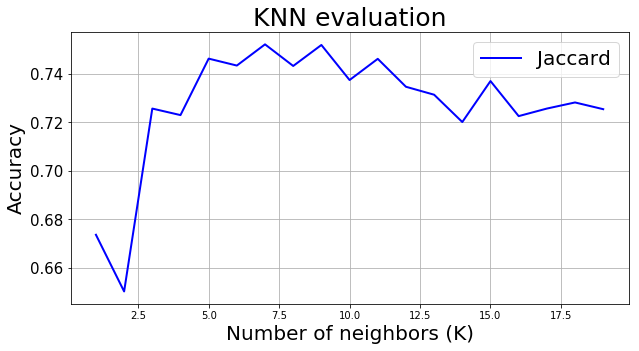

The highest Jaccard similarity index is 0.752 for Number of neighbors (K)= 7


In [59]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, jaccard_similarity_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
Ks = 20 # number of neighbors for KNN method
Jac_vals = np.zeros((Ks-1))

for n in range(1, Ks):
    # Build the model
    knn = KNeighborsClassifier(n_neighbors=n)
    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        knn.fit(X[train_index], y[train_index])
        yhat = knn.predict(X[test_index])
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    Jac_vals[n-1] = Jac_kfold_vals.mean()

# plot model evaluation and find the optimum parameter
model_par_name = 'Number of neighbors (K)'
model_name = 'KNN'
model_eval_plt(list(range(1, Ks)), Jac_vals, model_name, model_par_name)

**5.2** Build the final KNN model  
Use the K-value that maximizes the model accuracy based on evaluation graph to build the final KNN model

In [60]:
k=7
knn = KNeighborsClassifier(n_neighbors=k)
# knn.fit(X_train, y_train) # not sure if I should train the model on the entire data or only the training part!!!
knn.fit(X, y) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=7, p=2,
           weights='uniform')

As you can see, in addition to 'n_neighbors' there are other parameters that can be tuned in an attempt to achive higher accuracy, but we postpone is for now.

#### 5.2 Decision Tree

**5.2.1** Parameter tuning

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, wa

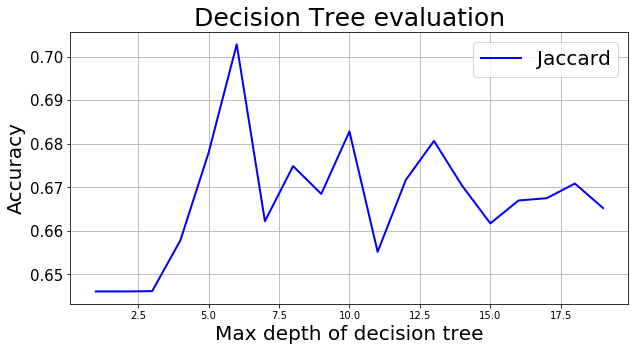

The highest Jaccard similarity index is 0.703 for Max depth of decision tree= 6


In [61]:
from sklearn.tree import DecisionTreeClassifier
maxDepths = 20
f1_vals = np.zeros((maxDepths-1))
Jac_vals = np.zeros((maxDepths-1))
for n in range(1, maxDepths):
    # Build the model
    loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        loanTree.fit(X[train_index], y[train_index])
        yhat = loanTree.predict(X[test_index])
        f1_kfold_vals[n2] = f1_score(y[test_index], yhat, average='weighted')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
    f1_vals[n-1] = f1_kfold_vals.mean()
    Jac_vals[n-1] = Jac_kfold_vals.mean()


# plot model evaluation and find the optimum parameter
model_par_name = 'Max depth of decision tree'
model_name = 'Decision Tree'
model_eval_plt(list(range(1, maxDepths)), f1_vals, model_name, model_par_name)


Considering both accuracy metrics, 6 is a better choice for 'max_depth' parameter.

**5.2.2** Build the final decision tree model:

In [62]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
# loanTree.fit(X_train,y_train)
loanTree.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Aagain we see there are other model parameters that can be tuned in addition to max_depth. For now we keep the default values for other model parameters.

#### 5.3 Support Vector Machine (SVM):

Which **kernel** results in highest accuracy?
Rebuild the model using 4 different kernels, compute the accuracy for each model, select the best kernel.  
Kernels to be tested: 

    1.Linear  
    2.Polynomial  
    3.Radial basis function (RBF)  
    4.Sigmoid  
    
Each of these functions has their own characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results.

**5.3.1** Parameter tuning:

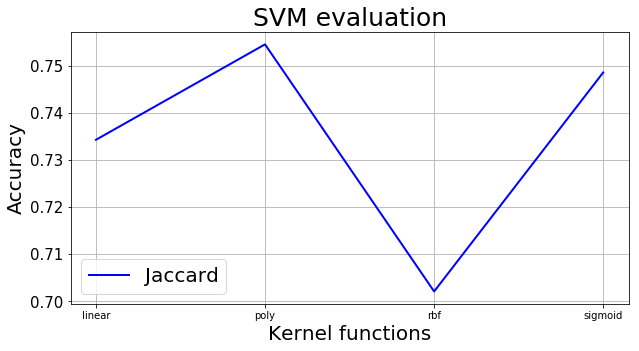

The highest Jaccard similarity index is 0.755 for Kernel functions= poly


In [63]:
from sklearn import svm

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
n=0
# F1_scores = np.zeros(len(kernels))
Jaccard_scores = np.zeros(len(kernels))

for myKernel in kernels:
    
    # Build the model
    loanSVM = svm.SVC(kernel=myKernel, gamma = 'auto')

    # perform a k-fold cross-validation to estimate the model accuracy
    folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
#     f1_kfold_vals = np.zeros((folds))
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        loanSVM.fit(X[train_index], y[train_index])
        yhat = loanSVM.predict(X[test_index])
#         f1_kfold_vals[n2] = f1_score(y[test_index], yhat, average='weighted')
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1
        
    # compute the mean accuracy based on accuracy of k-folds 
#     F1_scores[n-1] = f1_kfold_vals.mean()
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    
    
    n+=1

# plot model evaluation and find the optimum parameter
model_par_name = 'Kernel functions'
model_name = 'SVM'
model_eval_plt(kernels, Jaccard_scores, model_name, model_par_name)


This evaluation graph shows how a polynomial (degree 3, default) works better in terms of higher prediction accuracy when compared with other kernels.

There are other parameters that can be tuned e.g. the degree of the polynomial function. This is beyond the scope of this work. 
The figure shows both polynomial (default degree of 3) and rbf result in same accuracy.

**5.3.2** Build final SVM classifier:

In [64]:
loanSVM = svm.SVC(kernel='poly')
# loanSVM.fit(X_train, y_train)
loanSVM.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

#### 5.4 Logistic Regression

Logistic regression has a regularization parameter called C. Small values of C increase the regularization strength which will create simple models which underfit the data. Big values of C lower the power of regularization which imples the model is allowed to increase it's complexity, and therefore, overfit the data. 
Plot accuracy curves based on different C values to find the best for this dataset.

**5.4.1** Parameter tuning

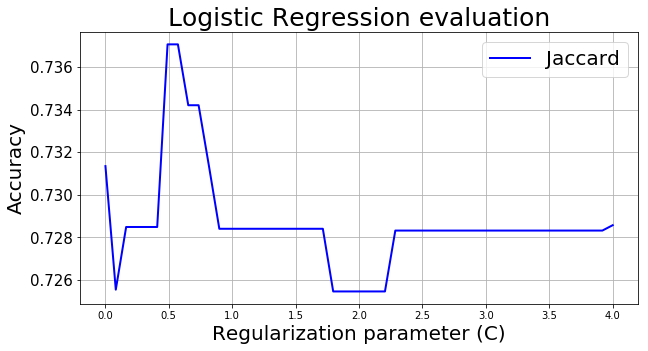

The highest Jaccard similarity index is 0.737 for Regularization parameter (C)= 0.4906734693877551


In [65]:
from sklearn.linear_model import LogisticRegression
Cvec = np.linspace(0.001, 4, 50)
n=0
Jaccard_scores = np.zeros(len(Cvec))
for myC in Cvec:
    # Build the model
    LR = LogisticRegression(C=myC, solver='liblinear')
    # perform a k-fold cross-validation to estimate the model accuracy
#     folds = 10
    kfold = KFold(folds, True, 1)
    n2 = 0
    Jac_kfold_vals = np.zeros((folds))
    # enumerate splits
    for train_index, test_index in kfold.split(X):
        LR.fit(X[train_index], y[train_index])
        yhat = LR.predict(X[test_index])
        Jac_kfold_vals[n2] = jaccard_similarity_score(y[test_index], yhat)
        n2+=1   
    # compute the mean accuracy based on accuracy of k-folds 
    Jaccard_scores[n-1] = Jac_kfold_vals.mean()
    n+=1


    
# plot model evaluation and find the optimum parameter
model_par_name = 'Regularization parameter (C)'
model_name = 'Logistic Regression'
model_eval_plt(list(Cvec), Jaccard_scores, model_name, model_par_name)

**5.4.2** Build final Logistic Regression classifier.

In [66]:
LR = LogisticRegression(C=0.5, solver='liblinear')
# LR.fit(X_train,y_train)
LR.fit(X,y)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

## 6. Use models to predict the target variable in new data

### 6.1 Preprocessing of new datset:

**Download** and **load** the new dataset:

In [67]:
# !wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
!wget -O loan_test.csv https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
print('Download complete!')

--2019-02-24 23:05:11--  https://raw.githubusercontent.com/Ehsan-Negahbani/Best-Classifier/master/loan_test.csv
Resolving raw.githubusercontent.com... 151.101.200.133
Connecting to raw.githubusercontent.com|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/plain]
Saving to: 'loan_test.csv'

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2019-02-24 23:05:11 (24.1 MB/s) - 'loan_test.csv' saved [3642/3642]

Download complete!


In [68]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


**Preprocess** new dataset
Preprocess in the same way as training data.

In [69]:
test_df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek # Monday:0, Sunday:6

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df = pd.concat([test_df,pd.get_dummies(test_df['education'])], axis=1)
test_df.drop(['education', 'Master or Above', 'effective_date', 'due_date'], inplace=True, axis = 1)
test_df.head()

,loan_status,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,PAIDOFF,1000,30,50,1,3,1,0,0
1,PAIDOFF,300,7,35,0,4,0,0,0
2,PAIDOFF,1000,30,43,1,5,0,1,0
3,PAIDOFF,1000,30,26,0,5,0,0,1
4,PAIDOFF,800,15,29,0,6,1,0,0


Extract **features** and **target** data from new dataset:

In [70]:
# X_new = test_df['Principal', 'terms', 'age', 'Gender', 'dayofweek', 'Bechalor', 'High School or Below', 'college']
features = ['Principal', 'terms', 'age', 'Gender', 'dayofweek', 'Bechalor', 'High School or Below', 'college']
X_new = test_df[features]
X_new.head()

,Principal,terms,age,Gender,dayofweek,Bechalor,High School or Below,college
0,1000,30,50,1,3,1,0,0
1,300,7,35,0,4,0,0,0
2,1000,30,43,1,5,0,1,0
3,1000,30,26,0,5,0,0,1
4,800,15,29,0,6,1,0,0


In [71]:
X_new.dtypes

Principal               int64
terms                   int64
age                     int64
Gender                  int64
dayofweek               int64
Bechalor                uint8
High School or Below    uint8
college                 uint8
dtype: object

In [72]:
y_new = test_df['loan_status'].values
y_new[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

**Normalize** data

In [73]:
X_new = preprocessing.StandardScaler().fit(X_new).transform(X_new)
X_new[0:2]

/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/ehsannegahbani/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -0.28674019,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.10035907,
        -0.41702883, -0.79772404, -0.86135677]])

### 6.2 Predictive modeling on new dataset

In [74]:
# KNN
# Notice that we are now using the model we have built previously
yhat = knn.predict(X_new)
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))

Jaccard similarity index=0.704


In [75]:
# Descision Tree
yhat = loanTree.predict(X_new)
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))

Jaccard similarity index=0.741


In [76]:
# SVM
yhat = loanSVM.predict(X_new)
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))


Jaccard similarity index=0.741


In [77]:
# Logistic regression
yhat = LR.predict(X_new)
yhat_prob = LR.predict_proba(X_new) # for LogLoss score that works on the probability of model prediction
print('Jaccard similarity index={:3.3}'.format(jaccard_similarity_score(y_new, yhat)))
# print('LogLoss={:3.3}'.format(log_loss(y_new, yhat_prob, eps=1e-15, normalize=True, sample_weight=None, labels=None)))

Jaccard similarity index=0.759


# Report
You should be able to report the accuracy of the built model using different evaluation metrics.
1. I splitted the training data to test/training datasets, tuned the model for a parameter, then trained the model on the entire training data. Here is the results:

| Algorithm          | Jaccard | 
|--------------------|---------|
| KNN                | 0.65       | 
| Decision Tree      | 0.70       | 
| SVM                | 0.72       | 
| LogisticRegression | 0.74       | 


2. Next I used k-fold validation (instead of one split), obtained model accuracy measures, then selected the model parameter:

| Algorithm          | Jaccard | 
|--------------------|---------|
| KNN                |   0.67     | 
| Decision Tree      |      0.74|
| SVM                |      0.74|
| LogisticRegression |        0.76|  

This slightly increased the accuracies from different classifiers. Looks like that **decision trees** are the winner for now.


This notebook is inspired by the contents from final project notebook for "Machine Learning"<p> <a href="https://www.coursera.org/learn/machine-learning-with-python">course </a> by IBM on coursera.
